<a href="https://colab.research.google.com/github/arghaboksi/CS6910-Deep-Learning/blob/main/CS6910_Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
#!pip install wandb -qqq
import wandb
from wandb.keras import WandbCallback

In [6]:
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
import math
from sklearn.metrics import accuracy_score

In [7]:
wandb.login()

wandb: Currently logged in as: ma20m022 (use `wandb login --relogin` to force relogin)


True

In [8]:
wandb.init(project="ma20m022_cs21d407", entity="shubham-argha")

In [9]:
#fashion mnist data 
fashion_mnist = keras.datasets.fashion_mnist

In [10]:
#training data and test data
(training_images, training_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [11]:
#training and validation data
from sklearn.model_selection import train_test_split
training_images, val_images, training_labels, val_labels = train_test_split(training_images, training_labels, test_size=0.10, random_state=42)

In [12]:
print(training_images.shape)     #54k training images
print(training_labels.shape)     
print(test_images.shape)         #10k test images
print(test_labels.shape)
print(val_images.shape)         #6k test images
print(val_labels.shape)

(54000, 28, 28)
(54000,)
(10000, 28, 28)
(10000,)
(6000, 28, 28)
(6000,)


In [13]:
#Flattening the training and test examples
#Each column is a flattened image
training_images_flatten = training_images.reshape(training_images.shape[0], -1).T
print(training_images_flatten.shape)
test_images_flatten = test_images.reshape(test_images.shape[0], -1).T
print(test_images_flatten.shape)
val_images_flatten = val_images.reshape(val_images.shape[0], -1).T
print(val_images_flatten.shape)


# Standardize data
train_data = training_images_flatten/255
test_data = test_images_flatten/255
val_data = val_images_flatten/255
print("train data shape : ", train_data.shape)
print("test data shape : ", test_data.shape)
print("val data shape : ", val_data.shape)

(784, 54000)
(784, 10000)
(784, 6000)
train data shape :  (784, 54000)
test data shape :  (784, 10000)
val data shape :  (784, 6000)


In [14]:
#One hot Encoding for labels
train_labels = np.transpose(to_categorical(training_labels))
testing_labels = np.transpose(to_categorical(test_labels))
validation_labels = np.transpose(to_categorical(val_labels))
print(train_labels.shape)
print(testing_labels.shape)
print(validation_labels.shape)

(10, 54000)
(10, 10000)
(10, 6000)


[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


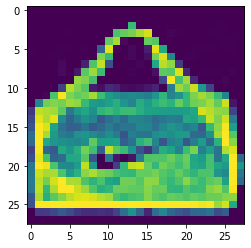

In [15]:
print(train_labels[:, 205])
plt.imshow(training_images[205])

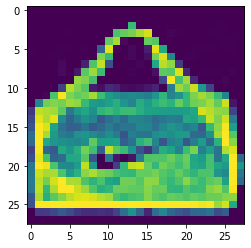

In [16]:
plt.imshow(training_images_flatten[:, 205].reshape(28,28))

In [17]:
# Question 1
# 0: T-shirt/top
# 1: Trouser
# 2: Pullover
# 3: Dress
# 4: Coat
# 5: Sandal
# 6: Shirt
# 7: Sneaker
# 8: Bag
# 9: Ankle boot

image = [];
items = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]
labels = [0,1,2,3,4,5,6,7,8,9]

for k in labels:
    for j in range(len(training_labels)):
        if k == training_labels[j]:
            image.append(training_images[j])
            break 

wandb.log({"Examples": [ wandb.Image(img, caption=caption) for img, caption in zip(image,items)]})

In [18]:
# L : a list containing no. of neurons in different layers, L = [4,4,2] means 4 input neurons, one hidden layer with 4 neurons, 2 output neurons
# params : a dictionary containing weights and biases of different layers

def parameter_initialise_random(L):
    no_of_layers = len(L)
    params = {}
    for i in range(1, no_of_layers):
        params['W' + str(i)] = np.random.randn(L[i], L[i-1]) * 0.01
        params['b' + str(i)] = np.zeros((L[i], 1))
    return params

In [19]:
# Xavier Weight Initialization

def parameter_initialise_xavier(L):
    no_of_layers = len(L)
    params = {}
    for i in range(1, no_of_layers):
        lower = -1/ np.sqrt(L[i-1])
        upper = 1/ np.sqrt(L[i-1])
        params["W" + str(i)] = lower + np.random.randn(L[i], L[i-1])*(upper- lower)
        params["b" + str(i)] = lower + np.random.randn(L[i],1)*(upper - lower)
    return params

In [20]:
# Linear Computation of a layer
def linear_computation_of_a_layer(activations_prev_layer, weights_of_current_layer, biases_of_current_layer):
    preactivation = np.dot(weights_of_current_layer, activations_prev_layer) + biases_of_current_layer
    return preactivation

In [21]:
# Relu activation function
def relu(v):
    return np.maximum(0,v)

In [22]:
# Sigmoid activation function
def sigmoid(v):
    return 1/(1+np.exp(-v))

In [23]:
# tanh activation function
def tanh(x):
	  return np.tanh(x)

In [24]:
def softmax(vector):
	e = np.exp(vector)
	return e / e.sum()

In [25]:
def relu_derivative(vector):
    return (vector>0)*(np.ones(np.shape(vector)))

In [26]:
#activation of a layer
def activation_of_a_layer(activations_prev_layer, weights_of_current_layer, biases_of_current_layer, activation_function):
    preactivation = linear_computation_of_a_layer(activations_prev_layer, weights_of_current_layer, biases_of_current_layer)
    if activation_function == "sigmoid":
        activation = sigmoid(preactivation)
    if activation_function == "tanh":
        activation = tanh(preactivation)
    if activation_function == "relu":
        activation = relu(preactivation)
    return preactivation, activation

In [27]:
# Forward propagation for a single training example
def forward_propagation(input_vector, parameters, activation_function):
    activation_preactivation_dictionary = {}
    activation_preactivation_dictionary['h0'] = input_vector
    activation = input_vector
    L = len(parameters)//2     
    for i in range(1, L):      #calculates activation of L-1 layers
        A_temp = activation
        preactivation, activation = activation_of_a_layer(A_temp, parameters['W'+str(i)], parameters['b'+str(i)], activation_function)
        activation_preactivation_dictionary['a'+str(i)] = preactivation
        activation_preactivation_dictionary['h'+str(i)] = activation
    #Output layer is softmax, need to write the softmax code here
    preactivation = linear_computation_of_a_layer(activation, parameters['W'+str(L)], parameters['b'+str(L)])
    output_layer_activation = softmax(preactivation)
    activation_preactivation_dictionary['a'+str(L)] = preactivation
    activation_preactivation_dictionary['h'+str(L)] = output_layer_activation
    return output_layer_activation, activation_preactivation_dictionary

In [28]:
def predictions(input_batch, parameters, activation_function):
    no_of_examples = np.shape(input_batch)[1]
    predictions = []
    for i in range(no_of_examples):
        prediction, _ = forward_propagation(input_batch[:, i].reshape(784,1), parameters, activation_function)
        predictions.append(np.argmax(prediction,axis = 0))
    return predictions

In [29]:
# Cross Entropy Loss
def cross_entropy(target,output):
    return -np.log(np.dot(target,np.transpose(output)))

In [30]:
def get_losses(input_batch, input_labels,parameters, activation_function):
    no_of_examples = np.shape(input_batch)[1]
    loss = 0
    for i in range(no_of_examples):
        prediction, _ = forward_propagation(input_batch[:, i].reshape(784,1), parameters, activation_function)
        loss+=cross_entropy(input_labels[:, i], prediction.reshape(10,))
    loss = (1/no_of_examples)*loss
    return loss

In [31]:
# Backpropagation for a single training example
def backward_propagation(target, output,act_preact_dict,input_shape,parameters, activation_function,reg_par):
    L = (len(parameters))//2
    act_preact_dict['a0'] = np.zeros((input_shape,1))
    derivatives = dict()
    derivatives['delta_a'+str(L)] = -1*(target.reshape((-1,1))-output)
    for i in range(L,0,-1):
        derivatives['delta_w'+str(i)] = np.dot(derivatives['delta_a'+str(i)],(act_preact_dict['h'+str(i-1)]).T)+reg_par*parameters['W' + str(i)]
        derivatives['delta_b'+str(i)] = derivatives['delta_a'+str(i)]
        derivatives['delta_h'+str(i-1)] = np.dot((parameters['W' + str(i)]).T,derivatives['delta_a'+str(i)])
        if activation_function == "sigmoid":
            derivatives['delta_a' + str(i-1)] = (derivatives['delta_h' + str(i-1)])*sigmoid(act_preact_dict["a" + str(i-1)])*(1-sigmoid(act_preact_dict["a" + str(i-1)]))
        elif activation_function == "tanh":
            derivatives['delta_a' + str(i-1)] = (derivatives['delta_h' + str(i-1)])*(1-(tanh(act_preact_dict["a" + str(i-1)]))**2)
        elif activation_function == "relu":
            derivatives['delta_a' + str(i-1)] = (derivatives['delta_h' + str(i-1)])*(relu_derivative(act_preact_dict["a" + str(i-1)]))
    return derivatives

In [32]:
def mini_batch_gradient_descent_update_rule(parameters, learning_rate, derivatives):

    L = len(parameters) // 2 

    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate*derivatives["dw" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate*derivatives["db" + str(l+1)]

    return parameters

In [33]:
def forward_backward(train_data, train_labels, parameters, layer_dimensions, activation_function,reg_par):
  
    no_of_examples = np.shape(train_data)[1]
    L = len(parameters)//2
    loss = 0
    # Initialise Gradient Dictionary, after processing all the training examples this will contain the gradients
    gradients = {}
    for k in range(1, L+1):
        gradients["dw" + str(k)] = np.zeros((layer_dimensions[k], layer_dimensions[k-1]))
        gradients["db" + str(k)] = np.zeros((layer_dimensions[k],1))

    # Forward  and Backward propagation for m training examples
    for i in range(no_of_examples):

        # Forward prop for ith training example
        predictions, act_preact_dict = forward_propagation(train_data[:, i].reshape(784,1), parameters, activation_function)
        
        # Backward prop for ith training example
        derivative_dict = backward_propagation(train_labels[:, i], predictions, act_preact_dict, 784, parameters,activation_function,reg_par)

        for key in gradients.keys():
            gradients[key] += derivative_dict['delta_'+key[1:]]

        loss += cross_entropy(train_labels[:, i], predictions.reshape(10,))

    # Need to take the average of the gradients and loss
    for key in gradients.keys():
        gradients[key] = (1/no_of_examples)*gradients[key]

    loss = (1/no_of_examples)*loss
    
    return (loss, gradients)


In [34]:
# Generates mini batches from the training data
def mini_batch_generation(train_data, train_labels, batch_size = 64):
    
    no_of_training_examples = train_data.shape[1]                 
    batches = []

    number_of_complete_minibatches = math.floor(no_of_training_examples/batch_size)

    for i in range(number_of_complete_minibatches):
        batch_input = train_data[:, i*batch_size : (i+1)*batch_size]
        batch_output = train_labels[:, i*batch_size : (i+1)*batch_size]
        created_batch = (batch_input, batch_output)
        batches.append(created_batch)
    
    if no_of_training_examples % batch_size != 0:
        last_batch_input = train_data[:, int(no_of_training_examples/batch_size)*batch_size : ]
        last_batch_output = train_labels[:, int(no_of_training_examples/batch_size)*batch_size : ]
        last_batch = (last_batch_input, last_batch_output)
        batches.append(last_batch)
    
    return batches

In [37]:
# if batch_size = 1, then this function implements SGD
# if batch_size = m, then this function implements Vanilla Gradient Descent
def mini_batch_gradient_descent(train_data, train_labels, number_of_hidden_layers, hidden_layer_size, learning_rate, batch_size, number_of_epochs, activation_function, initialization,reg_par):
    
    l = []
    for i in range(number_of_hidden_layers):
        l.append(hidden_layer_size)
    layer_dimensions = [784] + l + [10]

    number_of_training_examples = np.shape(train_data)[1]
    
    if initialization == 'random':
        parameters = parameter_initialise_random(layer_dimensions)
    if initialization == "xavier":
        parameters = parameter_initialise_xavier(layer_dimensions)
    
    number_of_layers = len(layer_dimensions)
    batches = mini_batch_generation(train_data, train_labels, batch_size)
    losses = []

    for i in range(number_of_epochs):
        for batch in batches:
            (current_batch_input, current_batch_output) = batch
            (loss, gradients) = forward_backward(current_batch_input, current_batch_output, parameters, layer_dimensions, activation_function,reg_par)
            losses.append(loss)
            parameters = mini_batch_gradient_descent_update_rule(parameters, learning_rate, gradients)
        preds_val = predictions(val_data, parameters, activation_function)
        acc_val = accuracy_score(val_labels, preds_val)
        preds_train = predictions(train_data, parameters, activation_function)
        acc_train = accuracy_score(training_labels, preds_train)
        val_loss = get_losses(val_data, validation_labels,parameters,activation_function)
        #wandb.log({"train_acc": acc_train, "train_loss": losses[-1], "val_acc": acc_val, "val_loss":val_loss, 'accuracy': acc_val})
        # wandb.log({"val_acc": acc_val})
        # wandb.log({'accuracy': acc_val})
        # wandb.log({'train_acc': acc_train})
        # wandb.log({'train_loss': losses[-1]})
        # wandb.log({'val_loss': val_loss})
    return losses,parameters

In [38]:
losses,parameters = mini_batch_gradient_descent(train_data, train_labels, 2,16, 0.01, 64, 2, 'sigmoid', 'xavier',0)

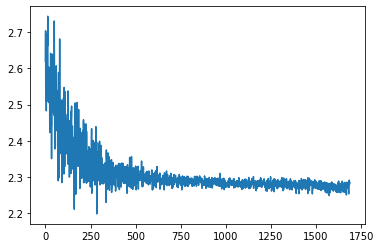

In [40]:
plt.plot(losses)
plt.show()

In [41]:
def momentum(train_data, train_labels, number_of_hidden_layers, hidden_layer_size, learning_rate, batch_size, number_of_epochs,gamma, activation_function, initialization,reg_par):
    l = []
    for i in range(number_of_hidden_layers):
        l.append(hidden_layer_size)
    layer_dimensions = [784] + l + [10]
    number_of_training_examples = np.shape(train_data)[1]
    
    if initialization == 'random':
        parameters = parameter_initialise_random(layer_dimensions)
    if initialization == "xavier":
        parameters = parameter_initialise_xavier(layer_dimensions)
    
    L = len(parameters)//2
    number_of_layers = len(layer_dimensions)
    batches = mini_batch_generation(train_data, train_labels, batch_size)
    momentum = {}
    losses = []
    
    for k in range(1, L+1):
        momentum["dw" + str(k)] = np.zeros((layer_dimensions[k], layer_dimensions[k-1]))
        momentum["db" + str(k)] = np.zeros((layer_dimensions[k],1))
    
    momentum_prev = {}
    
    for k in range(1, L+1):
        momentum_prev["dw" + str(k)] = np.zeros((layer_dimensions[k], layer_dimensions[k-1]))
        momentum_prev["db" + str(k)] = np.zeros((layer_dimensions[k],1))
    
    for i in range(number_of_epochs):
        
        for batch in batches:
            (current_batch_input, current_batch_output) = batch
            (loss, gradients) = forward_backward(current_batch_input, current_batch_output, parameters, layer_dimensions, activation_function,reg_par)
            losses.append(loss)
            
            for k in range(1, L+1):
                momentum["dw" + str(k)] = gamma*momentum_prev["dw" + str(k)]+learning_rate*gradients["dw" + str(k)]
                momentum["db" + str(k)] = gamma*momentum_prev["db" + str(k)]+learning_rate*gradients["db" + str(k)]
                parameters['W'+str(k)] = parameters['W'+str(k)] - momentum["dw" + str(k)]
                parameters['b'+str(k)] = parameters['b'+str(k)] - momentum["db" + str(k)]
                momentum_prev["dw" + str(k)] = momentum["dw" + str(k)]
                momentum_prev["db" + str(k)] = momentum["db" + str(k)]
    
        preds_val = predictions(val_data, parameters, activation_function)
        acc_val = accuracy_score(val_labels, preds_val)
        preds_train = predictions(train_data, parameters, activation_function)
        acc_train = accuracy_score(training_labels, preds_train)
        val_loss = get_losses(val_data, validation_labels,parameters,activation_function)
        #wandb.log({"train_acc": acc_train, "train_loss": losses[-1], "val_acc": acc_val, "val_loss":val_loss, 'accuracy': acc_val})
        # wandb.log({"val_acc": acc_val})
        # wandb.log({'accuracy': acc_val})
        # wandb.log({'train_acc': acc_train})
        # wandb.log({'train_loss': losses[-1]})
        # wandb.log({'val_loss': val_loss})
    
    return losses,parameters

In [43]:
losses,parameters = momentum(train_data, train_labels, 3,32, 2, 64, 1,0.1, 'sigmoid', 'xavier',0)

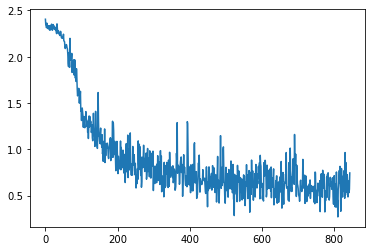

In [44]:
plt.plot(losses)
plt.show()

In [46]:
def nesterov(train_data, train_labels, number_of_hidden_layers, hidden_layer_size, learning_rate, batch_size, number_of_epochs,gamma, activation_function, initialization,reg_par):
    l = []
    for i in range(number_of_hidden_layers):
        l.append(hidden_layer_size)
    layer_dimensions = [784] + l + [10]
    number_of_training_examples = np.shape(train_data)[1]
    
    if initialization == 'random':
        parameters = parameter_initialise_random(layer_dimensions)
    if initialization == "xavier":
        parameters = parameter_initialise_xavier(layer_dimensions)
    
    L = len(parameters)//2
    number_of_layers = len(layer_dimensions)
    batches = mini_batch_generation(train_data, train_labels, batch_size)
    momentum = {}
    losses = []
    
    for k in range(1, L+1):
        momentum["dw" + str(k)] = np.zeros((layer_dimensions[k], layer_dimensions[k-1]))
        momentum["db" + str(k)] = np.zeros((layer_dimensions[k],1))
    
    momentum_prev = {}
    
    for k in range(1, L+1):
        momentum_prev["dw" + str(k)] = np.zeros((layer_dimensions[k], layer_dimensions[k-1]))
        momentum_prev["db" + str(k)] = np.zeros((layer_dimensions[k],1))
    
    for i in range(number_of_epochs):
        
        for batch in batches:
            (current_batch_input, current_batch_output) = batch
            look_ahead = {}
            
            for k in range(1, L+1):
                look_ahead['W'+str(k)] = parameters['W'+str(k)] - gamma*momentum_prev["dw" + str(k)]
                look_ahead['b'+str(k)] = parameters['b'+str(k)] - gamma*momentum_prev["db" + str(k)]
            
            (loss, gradients) = forward_backward(current_batch_input, current_batch_output, look_ahead, layer_dimensions, activation_function,reg_par)
            losses.append(loss)
            
            for k in range(1, L+1):
                momentum["dw" + str(k)] = gamma*momentum_prev["dw" + str(k)]+learning_rate*gradients["dw" + str(k)]
                momentum["db" + str(k)] = gamma*momentum_prev["db" + str(k)]+learning_rate*gradients["db" + str(k)]
                parameters['W'+str(k)] = parameters['W'+str(k)] - momentum["dw" + str(k)]
                parameters['b'+str(k)] = parameters['b'+str(k)] - momentum["db" + str(k)]
                momentum_prev["dw" + str(k)] = momentum["dw" + str(k)]
                momentum_prev["db" + str(k)] = momentum["db" + str(k)]

        preds_val = predictions(val_data, parameters, activation_function)
        acc_val = accuracy_score(val_labels, preds_val)
        preds_train = predictions(train_data, parameters, activation_function)
        acc_train = accuracy_score(training_labels, preds_train)
        val_loss = get_losses(val_data, validation_labels,parameters,activation_function)
        #wandb.log({"train_acc": acc_train, "train_loss": losses[-1], "val_acc": acc_val, "val_loss":val_loss, 'accuracy': acc_val})
        # wandb.log({"val_acc": acc_val})
        # wandb.log({'accuracy': acc_val})
        # wandb.log({'train_acc': acc_train})
        # wandb.log({'train_loss': losses[-1]})
        # wandb.log({'val_loss': val_loss})
    
    return losses,parameters

In [47]:
losses,parameters = nesterov(train_data, train_labels, 3,32, 2, 64, 1,0.1, "sigmoid", "xavier",0)

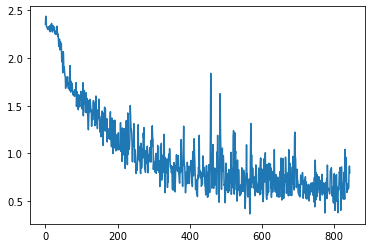

In [48]:
plt.plot(losses)
plt.show()

In [49]:
def rms_prop(train_data, train_labels, number_of_hidden_layers, hidden_layer_size, learning_rate, batch_size, number_of_epochs,beta,epsilon, activation_function, initialization,reg_par):
    l = []
    for i in range(number_of_hidden_layers):
        l.append(hidden_layer_size)
    layer_dimensions = [784] + l + [10]
    number_of_training_examples = np.shape(train_data)[1]
    if initialization == 'random':
        parameters = parameter_initialise_random(layer_dimensions)
    if initialization == "xavier":
        parameters = parameter_initialise_xavier(layer_dimensions)
    L = len(parameters)//2
    number_of_layers = len(layer_dimensions)
    batches = mini_batch_generation(train_data, train_labels, batch_size)
    momentum = {}
    losses = []
    for k in range(1, L+1):
        momentum["dw" + str(k)] = np.zeros((layer_dimensions[k], layer_dimensions[k-1]))
        momentum["db" + str(k)] = np.zeros((layer_dimensions[k],1))
    momentum_prev = {}
    for k in range(1, L+1):
        momentum_prev["dw" + str(k)] = np.zeros((layer_dimensions[k], layer_dimensions[k-1]))
        momentum_prev["db" + str(k)] = np.zeros((layer_dimensions[k],1))
    for i in range(number_of_epochs):
        for batch in batches:
            (current_batch_input, current_batch_output) = batch
            (loss, gradients) = forward_backward(current_batch_input, current_batch_output, parameters, layer_dimensions, activation_function,reg_par)
            losses.append(loss)
            for k in range(1, L+1):
                momentum["dw" + str(k)] = beta*momentum_prev["dw" + str(k)]+(1-beta)*(gradients["dw" + str(k)]**2)
                momentum["db" + str(k)] = beta*momentum_prev["db" + str(k)]+(1-beta)*(gradients["db" + str(k)]**2)
                parameters['W'+str(k)] = parameters['W'+str(k)] - (learning_rate/np.sqrt(momentum["dw" + str(k)]+epsilon))*gradients["dw" + str(k)]
                parameters['b'+str(k)] = parameters['b'+str(k)] - (learning_rate/np.sqrt(momentum["db" + str(k)]+epsilon))*gradients["db" + str(k)]
                momentum_prev["dw" + str(k)] = momentum["dw" + str(k)]
                momentum_prev["db" + str(k)] = momentum["db" + str(k)]
        preds_val = predictions(val_data, parameters, activation_function)
        acc_val = accuracy_score(val_labels, preds_val)
        preds_train = predictions(train_data, parameters, activation_function)
        acc_train = accuracy_score(training_labels, preds_train)
        val_loss = get_losses(val_data, validation_labels,parameters,activation_function)
        #wandb.log({"train_acc": acc_train, "train_loss": losses[-1], "val_acc": acc_val, "val_loss":val_loss, 'accuracy': acc_val})
        # wandb.log({"val_acc": acc_val})
        # wandb.log({'accuracy': acc_val})
        # wandb.log({'train_acc': acc_train})
        # wandb.log({'train_loss': losses[-1]})
        # wandb.log({'val_loss': val_loss})
    return losses,parameters

In [50]:
losses,parameters = rms_prop(train_data, train_labels, 3,32, 0.1, 64, 1,0.9,10**-5, "sigmoid", "xavier",0)

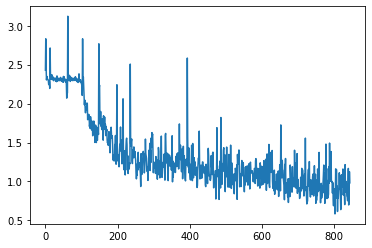

In [51]:
plt.plot(losses)
plt.show()

In [53]:
def adam(train_data, train_labels, number_of_hidden_layers, hidden_layer_size, learning_rate, batch_size, number_of_epochs,beta1,beta2,epsilon, activation_function, initialization,reg_par):

    l = []
    for i in range(number_of_hidden_layers):
        l.append(hidden_layer_size)
    layer_dimensions = [784] + l + [10]

    number_of_training_examples = np.shape(train_data)[1]
    if initialization == 'random':
        parameters = parameter_initialise_random(layer_dimensions)
    if initialization == "xavier":
        parameters = parameter_initialise_xavier(layer_dimensions)
    L = len(parameters)//2
    number_of_layers = len(layer_dimensions)
    batches = mini_batch_generation(train_data, train_labels, batch_size)
    losses = []
    time = 0
    m = {}
    for k in range(1, L+1):
        m["dw" + str(k)] = np.zeros((layer_dimensions[k], layer_dimensions[k-1]))
        m["db" + str(k)] = np.zeros((layer_dimensions[k],1))
    m_prev = {}
    for k in range(1, L+1):
        m_prev["dw" + str(k)] = np.zeros((layer_dimensions[k], layer_dimensions[k-1]))
        m_prev["db" + str(k)] = np.zeros((layer_dimensions[k],1))
        
    v = {}
    for k in range(1, L+1):
        v["dw" + str(k)] = np.zeros((layer_dimensions[k], layer_dimensions[k-1]))
        v["db" + str(k)] = np.zeros((layer_dimensions[k],1))
    v_prev = {}
    for k in range(1, L+1):
        v_prev["dw" + str(k)] = np.zeros((layer_dimensions[k], layer_dimensions[k-1]))
        v_prev["db" + str(k)] = np.zeros((layer_dimensions[k],1))
        
    for i in range(number_of_epochs):
        for batch in batches:
            (current_batch_input, current_batch_output) = batch
            (loss, gradients) = forward_backward(current_batch_input, current_batch_output, parameters, layer_dimensions, activation_function,reg_par)
            losses.append(loss)
            time+=1
            for k in range(1, L+1):
                m["dw" + str(k)] = beta1*m_prev["dw" + str(k)]+(1-beta1)*(gradients["dw" + str(k)])
                m["db" + str(k)] = beta1*m_prev["db" + str(k)]+(1-beta1)*(gradients["db" + str(k)])
                
                v["dw" + str(k)] = beta2*v_prev["dw" + str(k)]+(1-beta2)*(gradients["dw" + str(k)]**2)
                v["db" + str(k)] = beta2*v_prev["db" + str(k)]+(1-beta2)*(gradients["db" + str(k)]**2)
                
                m_hat_w = m["dw" + str(k)]/(1 - np.power(beta1, time))
                v_hat_w = v["dw" + str(k)]/(1 - np.power(beta2, time))
                m_hat_b = m["db" + str(k)]/(1 - np.power(beta1, time))
                v_hat_b = v["db" + str(k)]/(1 - np.power(beta2, time))
                
                parameters['W'+str(k)] = parameters['W'+str(k)] - (learning_rate/np.sqrt(v_hat_w + epsilon))*m_hat_w
                parameters['b'+str(k)] = parameters['b'+str(k)] - (learning_rate/np.sqrt(v_hat_b+epsilon))*m_hat_b
                
                m_prev["dw" + str(k)] = m["dw" + str(k)]
                m_prev["db" + str(k)] = m["db" + str(k)]
                
                v_prev["dw" + str(k)] = v["dw" + str(k)]
                v_prev["db" + str(k)] = v["db" + str(k)]
          
        preds_val = predictions(val_data, parameters, activation_function)
        acc_val = accuracy_score(val_labels, preds_val)
        preds_train = predictions(train_data, parameters, activation_function)
        acc_train = accuracy_score(training_labels, preds_train)
        val_loss = get_losses(val_data, validation_labels,parameters,activation_function)
        #wandb.log({"train_acc": acc_train, "train_loss": losses[-1], "val_acc": acc_val, "val_loss":val_loss, 'accuracy': acc_val})
        # wandb.log({"val_acc": acc_val})
        # wandb.log({'accuracy': acc_val})
        # wandb.log({'train_acc': acc_train})
        # wandb.log({'train_loss': losses[-1]})
        # wandb.log({'val_loss': val_loss})
        # wand.log({}, {})
    return losses, parameters

In [54]:
losses, parameters = adam(train_data, train_labels, 3,32, 0.1, 64, 1,0.9,0.999,10**-5, "sigmoid", "xavier",0)

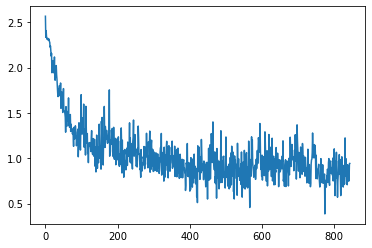

In [55]:
plt.plot(losses)
plt.show()

In [56]:
def nadam(train_data, train_labels, number_of_hidden_layers, hidden_layer_size, learning_rate, batch_size, number_of_epochs,beta1,beta2,epsilon, activation_function, initialization,reg_par):
    l = []
    for i in range(number_of_hidden_layers):
        l.append(hidden_layer_size)
    layer_dimensions = [784] + l + [10]
    number_of_training_examples = np.shape(train_data)[1]
    if initialization == 'random':
        parameters = parameter_initialise_random(layer_dimensions)
    if initialization == "xavier":
        parameters = parameter_initialise_xavier(layer_dimensions)
    L = len(parameters)//2
    number_of_layers = len(layer_dimensions)
    batches = mini_batch_generation(train_data, train_labels, batch_size)
    losses = []
    time = 0
    m = {}
    for k in range(1, L+1):
        m["dw" + str(k)] = np.zeros((layer_dimensions[k], layer_dimensions[k-1]))
        m["db" + str(k)] = np.zeros((layer_dimensions[k],1))
    m_prev = {}
    for k in range(1, L+1):
        m_prev["dw" + str(k)] = np.zeros((layer_dimensions[k], layer_dimensions[k-1]))
        m_prev["db" + str(k)] = np.zeros((layer_dimensions[k],1))
        
    v = {}
    for k in range(1, L+1):
        v["dw" + str(k)] = np.zeros((layer_dimensions[k], layer_dimensions[k-1]))
        v["db" + str(k)] = np.zeros((layer_dimensions[k],1))
    v_prev = {}
    for k in range(1, L+1):
        v_prev["dw" + str(k)] = np.zeros((layer_dimensions[k], layer_dimensions[k-1]))
        v_prev["db" + str(k)] = np.zeros((layer_dimensions[k],1))
        
    
    for i in range(number_of_epochs):
        for batch in batches:
            (current_batch_input, current_batch_output) = batch
            (loss, gradients) = forward_backward(current_batch_input, current_batch_output, parameters, layer_dimensions, activation_function,reg_par)
            losses.append(loss)
            time+=1
            for k in range(1, L+1):
                m["dw" + str(k)] = beta1*m_prev["dw" + str(k)]+(1-beta1)*(gradients["dw" + str(k)])
                m["db" + str(k)] = beta1*m_prev["db" + str(k)]+(1-beta1)*(gradients["db" + str(k)])
                
                v["dw" + str(k)] = beta2*v_prev["dw" + str(k)]+(1-beta2)*(gradients["dw" + str(k)]**2)
                v["db" + str(k)] = beta2*v_prev["db" + str(k)]+(1-beta2)*(gradients["db" + str(k)]**2)
                
                m_hat_w = m["dw" + str(k)]/(1 - np.power(beta1, time))
                v_hat_w = v["dw" + str(k)]/(1 - np.power(beta2, time))
                m_hat_b = m["db" + str(k)]/(1 - np.power(beta1, time))
                v_hat_b = v["db" + str(k)]/(1 - np.power(beta2, time))
                
                m_hat_w = beta1*m_hat_w+(1-beta1)*(gradients["dw" + str(k)])
                m_hat_b = beta1*m_hat_b+(1-beta1)*(gradients["db" + str(k)])
                
                parameters['W'+str(k)] = parameters['W'+str(k)] - (learning_rate/np.sqrt(v_hat_w + epsilon))*m_hat_w
                parameters['b'+str(k)] = parameters['b'+str(k)] - (learning_rate/np.sqrt(v_hat_b+epsilon))*m_hat_b
                
                m_prev["dw" + str(k)] = m["dw" + str(k)]
                m_prev["db" + str(k)] = m["db" + str(k)]
                
                v_prev["dw" + str(k)] = v["dw" + str(k)]
                v_prev["db" + str(k)] = v["db" + str(k)]
        preds_val = predictions(val_data, parameters, activation_function)
        acc_val = accuracy_score(val_labels, preds_val)
        preds_train = predictions(train_data, parameters, activation_function)
        acc_train = accuracy_score(training_labels, preds_train)
        val_loss = get_losses(val_data, validation_labels,parameters,activation_function)
        #wandb.log({"train_acc": acc_train, "train_loss": losses[-1], "val_acc": acc_val, "val_loss":val_loss, 'accuracy': acc_val})
        # wandb.log({"val_acc": acc_val})
        # wandb.log({'accuracy': acc_val})
        # wandb.log({'train_acc': acc_train})
        # wandb.log({'train_loss': losses[-1]})
        # wandb.log({'val_loss': val_loss})
    return losses, parameters

In [57]:
losses, parameters = nadam(train_data, train_labels, 3,32, 0.1, 64, 1,0.9,0.999,10**-5, "sigmoid", "xavier",0)

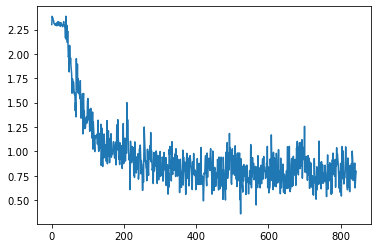

In [58]:
plt.plot(losses)
plt.show()

In [37]:
sweep_config = {
    'method': 'bayes',
    'metric': {
      'name': 'accuracy',
      'goal': 'maximize'   
    },
    'early_terminate': {
            'type': 'hyperband',
            'min_iter': [3],
            's': [2]
    },
    'parameters': {
        'num_of_epochs': {
            'values': [5,10] 
        },
        'number_of_hidden_layers': {
            'values': [3, 4, 5] 
        },
        'reg_para': {
            'values': [0, 0.0005, 0.5] 
        },
        'hidden_layer_size': {
            'values': [32, 64, 128] 
        },
        'learning_rate': {
            'values': [1e-3,1e-5] 
        },
        'optimizer': {
            'values': ['adam','nadam',"momentum",'nesterov',"rmsprop", 'sgd']
        },
        'batch_size' : {
            'values':[16, 32, 64]
        },
        'weight_initialization': {
            'values': ['random','xavier']
        },
        'activation': {
            'values': ['sigmoid','tanh','relu']
        }
        }
}

In [38]:
sweep_id = wandb.sweep(sweep_config, entity="shubham-argha", project="ma20m022_cs21d407")

wandb: WARNING Malformed sweep config detected! This may cause your sweep to behave in unexpected ways.
wandb: WARNING To avoid this, please fix the sweep config schema violations below:
wandb: WARNING   Violation 1. {'min_iter': [3], 's': [2], 'type': 'hyperband'} is not valid under any of the given schemas


Create sweep with ID: mu2j24xv
Sweep URL: https://wandb.ai/shubham-argha/ma20m022_cs21d407/sweeps/mu2j24xv


In [46]:
def train():
    config_defaults = {
        'num_of_epochs': 10,
        'number_of_hidden_layers': 5,
        'reg_para': 0,
        'hidden_layer_size': 64,
        'learning_rate': 1e-3,
        'optimizer': 'adam',
        'batch_size': 64,
        'activation': 'relu',
        'weight_initialization': 'xavier',
        'gamma' : 0.9,
        'epsilon' : 1e-5,
        'beta': 0.95,
        'beta1' : 0.9,
        'beta2' : 0.999
    }

    wandb.init(config=config_defaults,resume=True)
    config = wandb.config 
    wandb.run.name = "hl_" + str(config.number_of_hidden_layers)+ "_layer-size_" + str(config.hidden_layer_size) + "_bs_"+str(config.batch_size)+"_ac_"+ config.activation + "_init_" + str(config.weight_initialization) + "_opt_" + str(config.optimizer)
    

    if config.optimizer=='adam':
        adam(train_data, train_labels, config.number_of_hidden_layers, config.hidden_layer_size, config.learning_rate, config.batch_size, config.num_of_epochs, 
           config.beta1, config.beta2, config.epsilon, config.activation, config.weight_initialization,config.reg_para)
    elif config.optimizer=='nadam':
        nadam(train_data, train_labels, config.number_of_hidden_layers, config.hidden_layer_size, config.learning_rate, config.batch_size, config.num_of_epochs, 
            config.beta1, config.beta2, config.epsilon, config.activation, config.weight_initialization,config.reg_para)
    elif config.optimizer=="momentum":  
        momentum(train_data, train_labels, config.number_of_hidden_layers, config.hidden_layer_size, config.learning_rate, config.batch_size, config.num_of_epochs,
               config.gamma, config.activation, config.weight_initialization,config.reg_para)
    elif config.optimizer=='nesterov':
        nesterov(train_data, train_labels, config.number_of_hidden_layers, config.hidden_layer_size, config.learning_rate, config.batch_size, config.num_of_epochs,
               config.gamma, config.activation, config.weight_initialization,config.reg_para)
    elif config.optimizer=="rmsprop":
        rms_prop(train_data, train_labels, config.number_of_hidden_layers, config.hidden_layer_size, config.learning_rate, config.batch_size, config.num_of_epochs, 
               config.beta, config.epsilon, config.activation, config.weight_initialization,config.reg_para)
    elif config.optimizer=="sgd":
        mini_batch_gradient_descent(train_data, train_labels, config.number_of_hidden_layers,config.hidden_layer_size, config.learning_rate, config.batch_size, 
                config.number_of_epochs,config.activation, config.weight_initialization,config.reg_para)
    


In [47]:
wandb.agent('mu2j24xv',train,count=10)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: Agent Starting Run: 65k7b0v0 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 1e-05
wandb: 	num_of_epochs: 5
wandb: 	number_of_hidden_layers: 4
wandb: 	optimizer: adam
wandb: 	reg_para: 0.5
wandb: 	weight_initialization: xavier


accuracy,▁▁▁▁▁
train_acc,▁▁▁▁▁
train_loss,█▅▃▃▁
val_acc,▁▁▁▁▁
val_loss,█▆▄▂▁
accuracy,0.10183
train_acc,0.0998
train_loss,2.30329
val_acc,0.10183
val_loss,2.31215


wandb: Agent Starting Run: 3x5bmbt7 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	hidden_layer_size: 32
wandb: 	learning_rate: 1e-05
wandb: 	num_of_epochs: 10
wandb: 	number_of_hidden_layers: 3
wandb: 	optimizer: rmsprop
wandb: 	reg_para: 0.5
wandb: 	weight_initialization: random
wandb: Currently logged in as: ma20m022 (use `wandb login --relogin` to force relogin)


accuracy,▁▁▁▁▁▁▁▁▁▁
train_acc,▁▁▁▁▁▁▁▁▁▁
train_loss,▁▅▇███████
val_acc,▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▂▁▁▁▁▁▁▁
accuracy,0.09167
train_acc,0.10093
train_loss,2.30282
val_acc,0.09167
val_loss,2.30263


wandb: Agent Starting Run: qam1oi62 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	hidden_layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_of_epochs: 10
wandb: 	number_of_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	reg_para: 0.0005
wandb: 	weight_initialization: random


accuracy,▁▁▁▂▃▅▆▇▇█
train_acc,▁▁▁▂▃▅▆▇▇█
train_loss,███▆▅▅▄▂▁▁
val_acc,▁▁▁▂▃▅▆▇▇█
val_loss,███▆▅▄▃▂▁▁
accuracy,0.81533
train_acc,0.8218
train_loss,0.71642
val_acc,0.81533
val_loss,0.57177


wandb: Agent Starting Run: 676jgfgn with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 1e-05
wandb: 	num_of_epochs: 5
wandb: 	number_of_hidden_layers: 5
wandb: 	optimizer: rmsprop
wandb: 	reg_para: 0.5
wandb: 	weight_initialization: xavier


accuracy,▁▁▁▁▁
train_acc,▁▁▁▁▁
train_loss,▅█▆▄▁
val_acc,▁▁▁▁▁
val_loss,█▆▄▃▁
accuracy,0.1045
train_acc,0.0995
train_loss,2.32652
val_acc,0.1045
val_loss,2.30694


wandb: Agent Starting Run: gye188xj with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	hidden_layer_size: 32
wandb: 	learning_rate: 1e-05
wandb: 	num_of_epochs: 10
wandb: 	number_of_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	reg_para: 0.5
wandb: 	weight_initialization: xavier


accuracy,▇▇▇▁▁▁█▇▇▇
train_acc,▇▇▆▄▁▁▆███
train_loss,▂▁▁▃▅▇█▇▄▁
val_acc,▇▇▇▁▁▁█▇▇▇
val_loss,█▅▃▁▁▂▄▅▅▄
accuracy,0.09167
train_acc,0.10093
train_loss,2.4784
val_acc,0.09167
val_loss,2.37008


wandb: Agent Starting Run: 0uhcjhpi with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 1e-05
wandb: 	num_of_epochs: 10
wandb: 	number_of_hidden_layers: 3
wandb: 	optimizer: rmsprop
wandb: 	reg_para: 0.0005
wandb: 	weight_initialization: random


accuracy,▁▁▁▁▁▁▂▄▅█
train_acc,▁▁▁▁▁▁▃▄▅█
train_loss,████████▇▁
val_acc,▁▁▁▁▁▁▂▄▅█
val_loss,████████▇▁
accuracy,0.40183
train_acc,0.39848
train_loss,1.54921
val_acc,0.40183
val_loss,1.50305


wandb: Agent Starting Run: g7fkvw5v with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	hidden_layer_size: 32
wandb: 	learning_rate: 1e-05
wandb: 	num_of_epochs: 5
wandb: 	number_of_hidden_layers: 5
wandb: 	optimizer: nesterov
wandb: 	reg_para: 0.5
wandb: 	weight_initialization: xavier


accuracy,▁▁▁▁▁
train_acc,▁▁▁▁▁
train_loss,█▆▄▃▁
val_acc,▁▁▁▁▁
val_loss,█▆▄▂▁
accuracy,0.09833
train_acc,0.10019
train_loss,2.45504
val_acc,0.09833
val_loss,2.3735


wandb: Agent Starting Run: y1t4njbd with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	hidden_layer_size: 32
wandb: 	learning_rate: 1e-05
wandb: 	num_of_epochs: 5
wandb: 	number_of_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	reg_para: 0
wandb: 	weight_initialization: random


accuracy,▁▁▁▁▁
train_acc,▁▁▁▁▁
train_loss,█▆▄▃▁
val_acc,▁▁▁▁▁
val_loss,▁▃▅▆█
accuracy,0.09167
train_acc,0.10093
train_loss,2.30255
val_acc,0.09167
val_loss,2.30262


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 3qnu6uer with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_of_epochs: 5
wandb: 	number_of_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	reg_para: 0
wandb: 	weight_initialization: random


accuracy,▁▇███
train_acc,▁▇▇██
train_loss,█▄▃▁▁
val_acc,▁▇███
val_loss,█▂▂▁▁
accuracy,0.86167
train_acc,0.87643
train_loss,0.45587
val_acc,0.86167
val_loss,0.37778


wandb: Agent Starting Run: 2c50lkqj with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	hidden_layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_of_epochs: 5
wandb: 	number_of_hidden_layers: 5
wandb: 	optimizer: sgd
wandb: 	reg_para: 0.5
wandb: 	weight_initialization: random


wandb: ERROR Run 2c50lkqj errored: KeyError('number_of_epochs')


In [50]:
from sklearn.metrics import confusion_matrix
losses,parameters = rms_prop(train_data, train_labels, 3,128, 0.001, 32, 10,0.95,10**-5, "sigmoid", "xavier",0)
preds = predictions(test_data, parameters, 'sigmoid')

In [52]:
accuracy_score(test_labels, preds)

0.8526

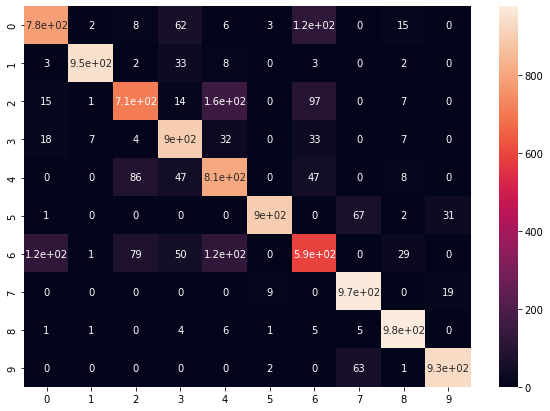

In [54]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
test_preds = predictions(test_data, parameters, 'sigmoid')
arr = confusion_matrix(test_labels, test_preds)
df_cm = pd.DataFrame(arr, index = [i for i in "0123456789"],
                  columns = [i for i in "0123456789"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

plt.savefig('Confusion Matrix.jpg')

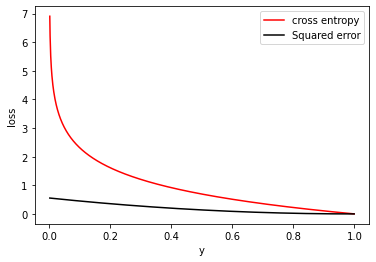

In [4]:
import numpy as np
import matplotlib.pyplot as plt
def vec(y):
    ans = np.zeros((10,1))
    ans[0] = y
    for i in range(1,10):
        ans[i] = (1-y)/9.0
    return ans
y = []
cross = []
mse = []
target = np.zeros((10,1))
target[0] = 1
for i in np.arange(0.001,1,0.001):
    y.append(i)
    cross.append(-np.log(i))
    mse.append(0.5*np.dot((target-vec(i)).T,target-vec(i))[0][0])
plt.plot(y,cross,'r-')
plt.plot(y,mse,'k-')
plt.xlabel('y')
plt.ylabel('loss')
plt.legend(['cross entropy', 'Squared error'])
plt.savefig('cross_entropy_vs_se.jpg')
plt.show()